In [1]:
#импортируем нужные библиотеки
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

In [2]:
#загружаем данные
participants = pd.read_csv('https://____/ab_test_participants.csv')
events = pd.read_csv('https://_____/ab_test_events.zip',
                     parse_dates=['event_dt'], low_memory=False)

In [3]:
#знакомимся с данными
participants.head(5)

,user_id,group,ab_test,device
0,0002CE61FF2C4011,B,interface_eu_test,Mac
1,001064FEAAB631A1,B,recommender_system_test,Android
2,001064FEAAB631A1,A,interface_eu_test,Android
3,0010A1C096941592,A,recommender_system_test,Android
4,001E72F50D1C48FA,A,interface_eu_test,Mac


In [4]:
#проверяем типы данных и пропуски
participants.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14525 entries, 0 to 14524
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  14525 non-null  object
 1   group    14525 non-null  object
 2   ab_test  14525 non-null  object
 3   device   14525 non-null  object
dtypes: object(4)
memory usage: 454.0+ KB


In [5]:
#так как нас интересует только тест interface_eu_test, сразу отфильтруем данные
participants_interface_eu_test = participants[participants['ab_test'] == 'interface_eu_test']

In [6]:
#проверяем данные на дубликаты
participants_interface_eu_test['user_id'].duplicated().sum()

0

In [7]:
#знакомимся с данными
events.head(5)

,user_id,event_dt,event_name,details
0,GLOBAL,2020-12-01 00:00:00,End of Black Friday Ads Campaign,ZONE_CODE15
1,CCBE9E7E99F94A08,2020-12-01 00:00:11,registration,0.0
2,GLOBAL,2020-12-01 00:00:25,product_page,NaN
3,CCBE9E7E99F94A08,2020-12-01 00:00:33,login,NaN
4,CCBE9E7E99F94A08,2020-12-01 00:00:52,product_page,NaN


In [8]:
#проверяем типы данных и пропуски
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 787286 entries, 0 to 787285
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   user_id     787286 non-null  object        
 1   event_dt    787286 non-null  datetime64[ns]
 2   event_name  787286 non-null  object        
 3   details     249022 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 24.0+ MB


Дубликаты в данном датасете проверять не имеет смысла, так как нет полей, подразумевающих уникальность. Столец `details` содержит пропуски, что также ок -- не все события имеют детализированную информацию (например, события авторизации). 

In [9]:
#посмотрим, какие события есть в датасете, чтобы отобрать нужные
events['event_name'].unique()

array(['End of Black Friday Ads Campaign', 'registration', 'product_page',
       'login', 'product_cart', 'purchase',
       'Start of Christmas&New Year Promo',
       'Start of CIS New Year Gift Lottery'], dtype=object)

In [10]:
#отфильтруем только события registration и purchase
events_goal = events[(events['event_name'] == 'registration') | (events['event_name'] == 'purchase')]

In [11]:
#объединим датасеты с пользователями и событиями 
merged_df = participants_interface_eu_test.merge(events_goal, on='user_id', how='left')

In [12]:
#сгруппируем пользователей и посчитаем кол-во по группам
group_a = merged_df[merged_df['group'] == 'A']['user_id'].nunique()
group_b = merged_df[merged_df['group'] == 'B']['user_id'].nunique()
print (f'В группе А: {group_a} пользователей, в группе В: {group_b} пользователей')

В группе А: 5383 пользователей, в группе В: 5467 пользователей


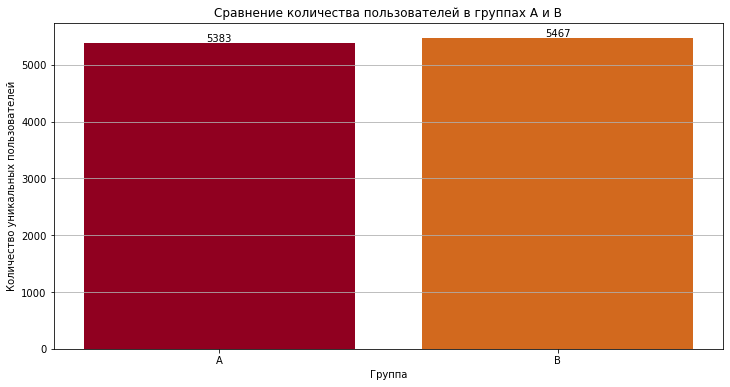

In [13]:
#строим столбчатую диаграмму по количеству пользователей в группах
plt.figure(figsize=(12, 6))

groups = ['A', 'B']
values = [group_a, group_b]

for i, v in enumerate(values):
    plt.text(i, v, str(v), ha='center', va='bottom')

plt.bar(groups, values, color=['#900020', '#D2691E'])
plt.title('Сравнение количества пользователей в группах А и В')
plt.xlabel('Группа')
plt.ylabel('Количество уникальных пользователей')
plt.grid(axis = 'y')
plt.show()

Пользователи по группам распределены достаточно равномерно. Проверим пересечения в группах:

In [14]:
#создаем множество пользователей из группы А
users_a = set(merged_df[merged_df['group'] == 'A']['user_id'].unique())
#создаем множество пользователей из группы В
users_b = set(merged_df[merged_df['group'] == 'B']['user_id'].unique())

#проверяем пересечение множеств
intersection = users_a & users_b

print(f"Пользователи, попавшие в обе группы: {len(intersection)}")


Пользователи, попавшие в обе группы: 0


In [15]:
#посчитаем дату регистрации для каждого user_id
registration_dates = merged_df[merged_df['event_name'] == 'registration'][['user_id', 'event_dt']]
registration_dates = registration_dates.rename(columns={'event_dt': 'registration_dt'})

#объединяем с исходной таблицей, чтобы у каждого события была дата регистрации
merged_with_reg_date = merged_df.merge(registration_dates, on='user_id', how='left')

#cчитаем разницу между событием и регистрацией (лайфтайм)
merged_with_reg_date['lifetime_days'] = (merged_with_reg_date['event_dt'] - merged_with_reg_date['registration_dt']).dt.days

#офильтруем события, которые произошли в течение первых 7 дней 
events_7_days = merged_with_reg_date[merged_with_reg_date['lifetime_days'] <= 7]

#отфильтруем данные только о покупках 
events_7_days_purchase = events_7_days[events_7_days['event_name'] == 'purchase']

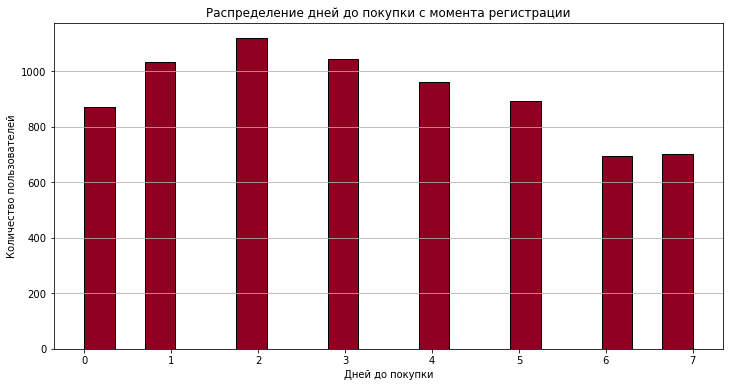

In [16]:
#построим гистограмму для распределения дней до покупки
plt.figure(figsize=(12, 6))
plt.hist(events_7_days_purchase['lifetime_days'], bins=20, color='#900020', edgecolor='black')
plt.title('Распределение дней до покупки с момента регистрации')
plt.xlabel('Дней до покупки')
plt.ylabel('Количество пользователей')
plt.grid(axis='y')
plt.show()

Данные по дням до покупки распределены нормально, со смещением вправо. Чаще всего покупают через 2 дня после регистрации, также частым результатом явлется 1 и 3 дня. 

In [17]:
import numpy as np
from statsmodels.stats.power import NormalIndPower

# Задаём параметры
p1 = 0.3  # базовая конверсия 
p2 = 0.33 #ожидаемый уровень конверсии
alpha = 0.05  #уровень значимости
beta = 0.2  # ошибка второго рода, часто 1 - мощность
power = 0.8  #мощность теста

# Инициализируем класс NormalIndPower
power_analysis = NormalIndPower()

# Рассчитываем размер выборки
sample_size = power_analysis.solve_power(
    effect_size = (p2 - p1) / np.sqrt((p1*(1-p1) + p2*(1-p2))/2),
    power = power,
    alpha = alpha,
    ratio = 1 # Равномерное распределение выборок
)

print(f"Необходимый размер выборки для каждой группы: {int(sample_size)}")

Необходимый размер выборки для каждой группы: 3759


Текущий размер выборок (5383/5467 пользователей) больше расчетного ✅

- рассчитайте для каждой группы количество посетителей, сделавших покупку, и общее количество посетителей.

In [18]:
#считаем общее количество пользователей
total_users_per_group = merged_df.groupby('group')['user_id'].nunique()

#считаем количество пользователей, сделавших покупку в течение 7 дней после регистраии
buyers_per_group = events_7_days_purchase.groupby('group')['user_id'].nunique()

In [19]:
#объединяем в одну таблицу
conversion_summary = pd.DataFrame({'total_users': total_users_per_group,'buyers': buyers_per_group})

# Добавляем столбец с конверсией в процентах
conversion_summary['conversion'] = ((conversion_summary['buyers'] / conversion_summary['total_users']) * 100).round(2)

display (conversion_summary)

,total_users,buyers,conversion
group,,,
A,5383,1542,28.65
B,5467,1687,30.86


Предварительно: после изменения интерфейса конверсия действительно выросла. Однако изменение конверсии составляет 2,2%, что меньше минимального ожидаемого эффекта по ТЗ (3%). 

Сформулируем гипотезы. 

**После изменения интерфейса сайта, конверсия зарегистрированных пользователей в покупателей (в течение 7 дней после регистрации):**

H0: конверсия в группе А = конверсии в группе B 

H1: конверсия в группе А < конверсии в группе B

In [20]:
#для проверки используем z-тест пропорций, так как имеем дело с долевой метрикой, 
# но сначала нужно проверить предпосылку о доcтаточном количестве данных

# n_a, n_b - все пользователи по группам
n_a, n_b = events_7_days[events_7_days['group'] == 'A'].shape[0], events_7_days[events_7_days['group'] == 'B'].shape[0]

# m_a, m_b - все покупатели по группам
m_a = events_7_days_purchase[events_7_days_purchase['group'] == 'A'].shape[0]
m_b = events_7_days_purchase[events_7_days_purchase['group'] == 'B'].shape[0]

# p_a, p_b - доли успехов по группам
p_a, p_b = m_a/n_a, m_b/n_b 

#выводим расчеты на экран
print(f'n_a={n_a}, n_b={n_b}')


print(f'm_a={m_a}, m_b={m_b}')


print(f'p_a={p_a}, p_b={p_b}')

#проверяем предпосылку о достаточном количестве данных
if (p_a*n_a > 10)and((1-p_a)*n_a > 10)and(p_b*n_b > 10)and((1-p_b)*n_b > 10):
    print('Предпосылка о достаточном количестве данных выполняется')
else:
    print('Предпосылка о достаточном количестве данных НЕ выполняется')

n_a=8522, n_b=9655
m_a=3139, m_b=4188
p_a=0.36834076507862007, p_b=0.43376488865872603
Предпосылка о достаточном количестве данных выполняется


In [21]:
#импортируем библиотеки для z-теста пропорций
from statsmodels.stats.proportion import proportions_ztest


#задаем уровень значимости
alpha = 0.05 

#считаем тест в одном направлении 
stat_ztest, p_value_ztest = proportions_ztest(
    [m_a, m_b],
    [n_a, n_b],
    alternative='smaller' 
)

if p_value_ztest > alpha:
    print(f'pvalue={p_value_ztest} > {alpha}')
    print('Нулевая гипотеза находит подтверждение! Доли успешных сессий в группах А и В равны.')
else:
    print(f'pvalue={p_value_ztest} < {alpha}')
    print('Нулевая гипотеза не находит подтверждения! Доля успешных сесий в группе В выше, чем в группе А.')

pvalue=1.4345536122905723e-19 < 0.05
Нулевая гипотеза не находит подтверждения! Доля успешных сесий в группе В выше, чем в группе А.


### Выводы по результатам A/B-теста

Мы провели A/B-тест с целью выяснить, влияет ли упрощение интерфейса сайта на увеличение конверсии пользователей в покупку.

Согласно результатам статистического теста, p-value = 1.43, что меньше 0.05, поэтому мы отвергаем нулевую гипотезу.

Это означает, что различие в конверсии между группами статистически значимо, и группа B (с новым интерфейсом) действительно показывает более высокую конверсию, чем группа A.


Конверсия в группе A: 28.65%

Конверсия в группе B: 30.86%

Абсолютный прирост: +2.21 процентных пункта.

В техническом задании была указана цель: увеличение конверсии как минимум на 3 процентных пункта.
Фактический прирост составил 2.21 п.п., то есть меньше запланированного значения.

**Итоговый вывод:**
Да, новый интерфейс работает лучше, и он статистически значимо улучшает поведение пользователей.
Однако, целевой прирост в +3% не достигнут, поэтому стоит либо еще доработать интерфейс, либо ориентироваться на полученное улучшение. 